# Referrence https://leemeng.tw/neural-machine-translation-with-transformer-and-tensorflow2.html

# 装依赖 & 下载数据

In [1]:
#beta 版本直接就有bug了
#!pip install tensorflow-gpu==2.0.0-beta0
!pip install tensorflow-gpu==2.0.0

In [2]:
import os
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pprint import pprint
from IPython.display import clear_output


# clear_output()

import tensorflow as tf
import tensorflow_datasets as tfds

print(tf.__version__)

2.0.0


## 改变日志等级

In [0]:
import logging
logging.basicConfig(level="ERROR")

np.set_printoptions(suppress=True)

## 设置一些变量

In [0]:
output_dir = "nmt"
en_vocab_file = os.path.join(output_dir, "en_vocab")
zh_vocab_file = os.path.join(output_dir, "zh_vocab")
checkpoint_path = os.path.join(output_dir, "checkpoints")
log_dir = os.path.join(output_dir, 'logs')
download_dir = "tensorflow-datasets/downloads"

if not os.path.exists(output_dir):
  os.makedirs(output_dir)

## 下载数据集

In [5]:
tmp_builder = tfds.builder("wmt19_translate/zh-en")
pprint(tmp_builder.subsets)

{NamedSplit('train'): ['newscommentary_v14',
                       'wikititles_v1',
                       'uncorpus_v1',
                       'casia2015',
                       'casict2011',
                       'casict2015',
                       'datum2015',
                       'datum2017',
                       'neu2017'],
 NamedSplit('validation'): ['newstest2018']}


In [0]:
# 解决楼下tensorflow2-beta0 的一个bug，现在改为不用beta0,所以这一步也跳过
#tensorflow.compat.v2.compat.v1 = tensorflow.compat.v1
#print(tensorflow._api.v2.compat.v2.compat.v1)

In [6]:
%%time
config = tfds.translate.wmt.WmtConfig(
  #version=tfds.core.Version('0.0.3', experiments={tfds.core.Experiment.S3: False}),
  version="0.0.1",
  language_pair=("zh", "en"),
  subsets={
    tfds.Split.TRAIN: ["newscommentary_v14"]
  }
)
import tensorflow as tensorflow

builder = tfds.builder("wmt_translate", config=config)
builder.download_and_prepare(download_dir=download_dir)
#clear_output()

Shuffling and writing examples to /root/tensorflow_datasets/wmt_translate/zh-en/0.0.1.incompleteLPQCCV/wmt_translate-train.tfrecord



Dataset wmt_translate downloaded and prepared to /root/tensorflow_datasets/wmt_translate/zh-en/0.0.1. Subsequent calls will reuse this data.
CPU times: user 4min 35s, sys: 38.7 s, total: 5min 13s
Wall time: 4min 2s


# 准备数据

In [7]:
# 切割资料集

train_perc = 20
val_prec = 1
drop_prec = 100 - train_perc - val_prec
"""
train, test, valid = tfds.Split.TRAIN.subsplit([train_perc, val_prec, drop_prec])
print(train, test, valid)
#train, test, valid = tfds.Split.TRAIN.subsplit([2, 1, 7])
#print(train, test, valid)
"""

'\ntrain, test, valid = tfds.Split.TRAIN.subsplit([train_perc, val_prec, drop_prec])\nprint(train, test, valid)\n#train, test, valid = tfds.Split.TRAIN.subsplit([2, 1, 7])\n#print(train, test, valid)\n'

In [8]:
# 只使用前面的 第三个不用
#examples = builder.as_dataset(split=split, as_supervised=True)
#train_examples, val_examples, _ = examples
# 现在只能用字符串语法糖来切数据集
train_examples, val_examples = builder.as_dataset(split=['train[:20%]', 'train[20%:21%]'], as_supervised=True)

print(train_examples)
print(val_examples)

<DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.string)>
<DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.string)>


In [9]:
# 原始数据取出来3条看看
for en, zh in train_examples.take(3):
  print(en)
  print(zh)
  print('-' * 10)

tf.Tensor(b'The fear is real and visceral, and politicians ignore it at their peril.', shape=(), dtype=string)
tf.Tensor(b'\xe8\xbf\x99\xe7\xa7\x8d\xe6\x81\x90\xe6\x83\xa7\xe6\x98\xaf\xe7\x9c\x9f\xe5\xae\x9e\xe8\x80\x8c\xe5\x86\x85\xe5\x9c\xa8\xe7\x9a\x84\xe3\x80\x82 \xe5\xbf\xbd\xe8\xa7\x86\xe5\xae\x83\xe7\x9a\x84\xe6\x94\xbf\xe6\xb2\xbb\xe5\xae\xb6\xe4\xbb\xac\xe5\x89\x8d\xe9\x80\x94\xe5\xa0\xaa\xe5\xbf\xa7\xe3\x80\x82', shape=(), dtype=string)
----------
tf.Tensor(b'In fact, the German political landscape needs nothing more than a truly liberal party, in the US sense of the word \xe2\x80\x9cliberal\xe2\x80\x9d \xe2\x80\x93 a champion of the cause of individual freedom.', shape=(), dtype=string)
tf.Tensor(b'\xe4\xba\x8b\xe5\xae\x9e\xe4\xb8\x8a\xef\xbc\x8c\xe5\xbe\xb7\xe5\x9b\xbd\xe6\x94\xbf\xe6\xb2\xbb\xe5\xb1\x80\xe5\x8a\xbf\xe9\x9c\x80\xe8\xa6\x81\xe7\x9a\x84\xe4\xb8\x8d\xe8\xbf\x87\xe6\x98\xaf\xe4\xb8\x80\xe4\xb8\xaa\xe7\xac\xa6\xe5\x90\x88\xe7\xbe\x8e\xe5\x9b\xbd\xe6\x89\x80\xe8\

In [0]:
# 解码中文
sample_examples = []
num_samples = 10

for en_t, zh_t in train_examples.take(num_samples):
  en = en_t.numpy().decode("utf-8")
  zh = zh_t.numpy().decode("utf-8")
  
  print(en)
  print(zh)
  print('-' * 10)
  
  # 之後用來簡單評估模型的訓練情況
  sample_examples.append((en, zh))

The fear is real and visceral, and politicians ignore it at their peril.
这种恐惧是真实而内在的。 忽视它的政治家们前途堪忧。
----------
In fact, the German political landscape needs nothing more than a truly liberal party, in the US sense of the word “liberal” – a champion of the cause of individual freedom.
事实上，德国政治局势需要的不过是一个符合美国所谓“自由”定义的真正的自由党派，也就是个人自由事业的倡导者。
----------
Shifting to renewable-energy sources will require enormous effort and major infrastructure investment.
必须付出巨大的努力和基础设施投资才能完成向可再生能源的过渡。
----------
In this sense, it is critical to recognize the fundamental difference between “urban villages” and their rural counterparts.
在这方面，关键在于认识到“城市村落”和农村村落之间的根本区别。
----------
A strong European voice, such as Nicolas Sarkozy’s during the French presidency of the EU, may make a difference, but only for six months, and at the cost of reinforcing other European countries’ nationalist feelings in reaction to the expression of “Gallic pride.”
法国担任轮值主席国期间尼古拉·萨科奇统一的欧洲声音可能让人耳目一新，但这种声音却只持续了短短六个月，而且付出了让其他欧洲国家在面对“高卢人的骄

## 建立中英文字典

In [10]:
# 建立字典
%%time
try:
  subword_encoder_en = tfds.features.text.SubwordTextEncoder.load_from_file(en_vocab_file)
  print(f"載入已建立的字典： {en_vocab_file}")
except:
  print("沒有已建立的字典，從頭建立。")
  subword_encoder_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
      (en.numpy() for en, _ in train_examples), 
      target_vocab_size=2**13) # 有需要可以調整字典大小
  
  # 將字典檔案存下以方便下次 warmstart
  subword_encoder_en.save_to_file(en_vocab_file)
  

print(f"字典大小：{subword_encoder_en.vocab_size}")
print(f"前 10 個 subwords：{subword_encoder_en.subwords[:10]}")
print()

沒有已建立的字典，從頭建立。
字典大小：8113
前 10 個 subwords：[', ', 'the_', 'of_', 'to_', 'and_', 's_', 'in_', 'a_', 'is_', 'that_']

CPU times: user 1min 36s, sys: 8.54 s, total: 1min 45s
Wall time: 1min 28s


In [0]:
# encode 一下 英文 试试
sample_string = 'Taiwan is beautiful.'
indices = subword_encoder_en.encode(sample_string)
indices

[3461, 7889, 9, 3502, 4379, 1134, 7903]

In [0]:
# decode 展示 subwordpieces TODO 查一下 wordpieces
print("{0:10}{1:6}".format("Index", "Subword"))
print("-" * 15)
for idx in indices:
  subword = subword_encoder_en.decode([idx])
  print('{0:5}{1:6}'.format(idx, ' ' * 5 + subword))

Index     Subword
---------------
 3461     Taiwan
 7889      
    9     is 
 3502     bea
 4379     uti
 1134     ful
 7903     .


In [0]:
# 这个就很直白了
sample_string = 'Taiwan is beautiful.'
indices = subword_encoder_en.encode(sample_string)
decoded_string = subword_encoder_en.decode(indices)
assert decoded_string == sample_string
pprint((sample_string, decoded_string))

('Taiwan is beautiful.', 'Taiwan is beautiful.')


In [11]:
%%time 
#大概得6分钟
try:
  subword_encoder_zh = tfds.features.text.SubwordTextEncoder.load_from_file(zh_vocab_file)
  print(f"載入已建立的字典： {zh_vocab_file}")
except:
  print("沒有已建立的字典，從頭建立。")
  subword_encoder_zh = tfds.features.text.SubwordTextEncoder.build_from_corpus(
      (zh.numpy() for _, zh in train_examples), 
      target_vocab_size=2**13, # 有需要可以調整字典大小
      max_subword_length=1) # 每一個中文字就是字典裡的一個單位
  
  # 將字典檔案存下以方便下次 warmstart 
  subword_encoder_zh.save_to_file(zh_vocab_file)

print(f"字典大小：{subword_encoder_zh.vocab_size}")
print(f"前 10 個 subwords：{subword_encoder_zh.subwords[:10]}")
print()

沒有已建立的字典，從頭建立。
字典大小：4205
前 10 個 subwords：['的', '，', '。', '国', '在', '是', '一', '和', '不', '这']

CPU times: user 7min 46s, sys: 7.92 s, total: 7min 54s
Wall time: 7min 38s


In [0]:
# 10条sample中打印一下
sample_string = sample_examples[5][1]
indices = subword_encoder_zh.encode(sample_string)
print(sample_string)
print(indices)

日本债券持有人大多为本国国民（甚至中央银行 ） ， 政治稳定符合他们的利益。
[207, 80, 260, 743, 103, 11, 12, 18, 53, 15, 80, 4, 4, 57, 60, 499, 267, 16, 517, 289, 38, 3981, 61, 3981, 2, 3981, 17, 124, 495, 89, 1028, 137, 32, 20, 1, 58, 282, 3]


In [0]:
en = "The eurozone’s collapse forces a major realignment of European politics."
zh = "欧元区的瓦解强迫欧洲政治进行一次重大改组。"

# 將文字轉成為 subword indices
en_indices = subword_encoder_en.encode(en)
zh_indices = subword_encoder_zh.encode(zh)

print("[英中原文]（轉換前）")
print(en)
print(zh)
print()
print('-' * 20)
print()
print("[英中序列]（轉換後）")
print(en_indices)
print(zh_indices)

[英中原文]（轉換前）
The eurozone’s collapse forces a major realignment of European politics.
欧元区的瓦解强迫欧洲政治进行一次重大改组。

--------------------

[英中序列]（轉換後）
[16, 900, 11, 6, 1527, 874, 8, 230, 2259, 2728, 239, 3, 89, 1236, 7903]
[44, 202, 168, 1, 852, 201, 231, 592, 44, 87, 17, 124, 106, 38, 7, 279, 86, 18, 212, 265, 3]


In [0]:
# 把原句子加 [BOS sentence EOS]
def encode(en_t, zh_t):
  # 因為字典的索引從 0 開始，
  # 我們可以使用 subword_encoder_en.vocab_size 這個值作為 BOS 的索引值
  # 用 subword_encoder_en.vocab_size + 1 作為 EOS 的索引值
  en_indices = [subword_encoder_en.vocab_size] + subword_encoder_en.encode(
      en_t.numpy()) + [subword_encoder_en.vocab_size + 1]
  # 同理，不過是使用中文字典的最後一個索引 + 1
  zh_indices = [subword_encoder_zh.vocab_size] + subword_encoder_zh.encode(
      zh_t.numpy()) + [subword_encoder_zh.vocab_size + 1]
  
  return en_indices, zh_indices

In [13]:
# 兼容 eager tensor 这个不是很理解
def tf_encode(en_t, zh_t):
  # 在 `tf_encode` 函式裡頭的 `en_t` 與 `zh_t` 都不是 Eager Tensors
  # 要到 `tf.py_funtion` 裡頭才是
  # 另外因為索引都是整數，所以使用 `tf.int64`
  return tf.py_function(encode, [en_t, zh_t], [tf.int64, tf.int64])

# `tmp_dataset` 為說明用資料集，說明完所有重要的 func，
# 我們會從頭建立一個正式的 `train_dataset`
tmp_dataset = train_examples.map(tf_encode)
en_indices, zh_indices = next(iter(tmp_dataset))
print(en_indices)
print(zh_indices)

tf.Tensor(
[8113   16 1284    9  243    5 1275 1756  156    1    5 1016 5566   21
   38   33 2982 7965 7903 8114], shape=(20,), dtype=int64)
tf.Tensor(
[4205   10  151  574 1298    6  374   55   29  193    5    1    3 3981
  931  431  125    1   17  124   33   20   97 1089 1247  861    3 4206], shape=(28,), dtype=int64)


In [0]:
train_dataset = train_examples.map(tf_encode)

In [0]:
# 这只是一个测试 只取长度 40 以内的 
MAX_LENGTH = 40

def filter_max_length(en, zh, max_length=MAX_LENGTH):
  # en, zh 分別代表英文與中文的索引序列
  return tf.logical_and(tf.size(en) <= max_length,
                        tf.size(zh) <= max_length)

# tf.data.Dataset.filter(func) 只會回傳 func 為真的例子
tmp_dataset = tmp_dataset.filter(filter_max_length)

In [0]:
# 因為我們數據量小可以這樣 count
num_examples = 0
for en_indices, zh_indices in train_dataset:
  cond1 = len(en_indices) <= MAX_LENGTH
  cond2 = len(zh_indices) <= MAX_LENGTH
  if cond1 & cond2:
    num_examples += 1

print(f"所有英文與中文序列長度都不超過 {MAX_LENGTH} 個 tokens")
print(f"訓練資料集裡總共有 {num_examples} 筆數據")

所有英文與中文序列長度都不超過 40 個 tokens
訓練資料集裡總共有 29784 筆數據


## 准备batch

In [0]:
# 测试一下 iter 语法
# https://www.tensorflow.org/guide/data#basic_mechanics
_dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1])
_dataset
for elem in _dataset:
  print(elem.numpy())

it = iter(_dataset)
print("-" * 10)
print(next(it).numpy())
print("-" * 10)
print(next(it).numpy())
print("-" * 10)
print(next(it).numpy())

8
3
0
8
2
1
----------
8
----------
3
----------
0


In [0]:
# batch 测试 增加padding 到 64
BATCH_SIZE = 64
# 將 batch 裡的所有序列都 pad 到同樣長度
tmp_dataset = tmp_dataset.padded_batch(BATCH_SIZE, padded_shapes=([-1], [-1]))
en_batch, zh_batch = next(iter(tmp_dataset))
print("英文索引序列的 batch")
print(en_batch)
print('-' * 20)
print("中文索引序列的 batch")
print(zh_batch)

英文索引序列的 batch
tf.Tensor(
[[8113   16 1284 ...    0    0    0]
 [8113 1894 1302 ...    0    0    0]
 [8113   44   40 ...    0    0    0]
 ...
 [8113  122  506 ...    0    0    0]
 [8113   16  215 ...    0    0    0]
 [8113 7443 7889 ...    0    0    0]], shape=(64, 39), dtype=int64)
--------------------
中文索引序列的 batch
tf.Tensor(
[[4205   10  151 ...    0    0    0]
 [4205  206  275 ...    0    0    0]
 [4205    5   10 ...    0    0    0]
 ...
 [4205   34    6 ...    0    0    0]
 [4205  317  256 ...    0    0    0]
 [4205  167  326 ...    0    0    0]], shape=(64, 40), dtype=int64)


In [0]:
# 这里才是实际对数据打padding 128 
MAX_LENGTH = 40
BATCH_SIZE = 128
BUFFER_SIZE = 15000

# 訓練集
train_dataset = (train_examples  # 輸出：(英文句子, 中文句子)
                 .map(tf_encode) # 輸出：(英文索引序列, 中文索引序列)
                 .filter(filter_max_length) # 同上，且序列長度都不超過 40
                 .cache() # 加快讀取數據
                 .shuffle(BUFFER_SIZE) # 將例子洗牌確保隨機性
                 .padded_batch(BATCH_SIZE, # 將 batch 裡的序列都 pad 到一樣長度
                               padded_shapes=([-1], [-1]))
                 .prefetch(tf.data.experimental.AUTOTUNE)) # 加速
# 驗證集
val_dataset = (val_examples
               .map(tf_encode)
               .filter(filter_max_length)
               .padded_batch(BATCH_SIZE, 
                             padded_shapes=([-1], [-1])))

In [0]:
%%time
en_batch, zh_batch = next(iter(train_dataset))
print("英文索引序列的 batch")
print(en_batch)
print('-' * 20)
print("中文索引序列的 batch")
print(zh_batch)

英文索引序列的 batch
tf.Tensor(
[[8113  122   40 ...    0    0    0]
 [8113 1063 1066 ...    0    0    0]
 [8113   87 1882 ...    0    0    0]
 ...
 [8113 1038 4000 ...    0    0    0]
 [8113 4450   11 ...    0    0    0]
 [8113 1496 5251 ... 7903 8114    0]], shape=(128, 36), dtype=int64)
--------------------
中文索引序列的 batch
tf.Tensor(
[[4205   10   51 ...    0    0    0]
 [4205   71   86 ...    0    0    0]
 [4205   10   72 ...    0    0    0]
 ...
 [4205  744   63 ...    0    0    0]
 [4205   62    5 ...    0    0    0]
 [4205   64  134 ...    3 4206    0]], shape=(128, 40), dtype=int64)
CPU times: user 21.2 s, sys: 4.17 s, total: 25.3 s
Wall time: 19.3 s


# 矩阵化的演练

In [21]:
# 原始词
demo_examples = [
    ("It is important.", "这很重要。"),
    ("The numbers speak for themselves.", "数字证明了一切。"),
]
pprint(demo_examples)

[('It is important.', '这很重要。'),
 ('The numbers speak for themselves.', '数字证明了一切。')]


In [22]:
batch_size = 2
demo_examples = tf.data.Dataset.from_tensor_slices((
    [en for en, _ in demo_examples], [zh for _, zh in demo_examples]
))


# 將兩個句子透過之前定義的字典轉換成子詞的序列（sequence of subwords）
# 並添加 padding token: <pad> 來確保 batch 裡的句子有一樣長度
demo_dataset = demo_examples.map(tf_encode)\
  .padded_batch(batch_size, padded_shapes=([-1], [-1]))

# 取出這個 demo dataset 裡唯一一個 batch
inp, tar = next(iter(demo_dataset))
print('inp:', inp)
print('' * 10)
print('tar:', tar)

inp: tf.Tensor(
[[8113  103    9 1066 7903 8114    0    0]
 [8113   16 4111 6735   12 2750 7903 8114]], shape=(2, 8), dtype=int64)

tar: tf.Tensor(
[[4205   10  241   86   27    3 4206    0    0    0]
 [4205  165  489  398  191   14    7  560    3 4206]], shape=(2, 10), dtype=int64)


# embedding

In [28]:
# + 2 是因為我們額外加了 <start> 以及 <end> tokens
vocab_size_en = subword_encoder_en.vocab_size + 2
vocab_size_zh = subword_encoder_zh.vocab_size + 2

# 為了方便 demo, 將詞彙轉換到一個 4 維的詞嵌入空間 为啥只有四维，这个embedding是根据啥
d_model = 4
embedding_layer_en = tf.keras.layers.Embedding(vocab_size_en, d_model)
embedding_layer_zh = tf.keras.layers.Embedding(vocab_size_zh, d_model)

emb_inp = embedding_layer_en(inp)
emb_tar = embedding_layer_zh(tar)
emb_inp, emb_tar

(<tf.Tensor: id=872750, shape=(2, 8, 4), dtype=float32, numpy=
 array([[[-0.01783348, -0.02148969, -0.03447568,  0.03482027],
         [-0.03162994, -0.02918538, -0.01197243,  0.02280189],
         [ 0.01017652, -0.00808194,  0.03609213, -0.03603267],
         [ 0.01691816, -0.00594858,  0.00405382,  0.01231674],
         [-0.01214153, -0.00000051,  0.02779266,  0.02651142],
         [-0.00580274,  0.04611101,  0.03515575, -0.01975439],
         [ 0.01616311, -0.02007253, -0.00850936, -0.04276091],
         [ 0.01616311, -0.02007253, -0.00850936, -0.04276091]],
 
        [[-0.01783348, -0.02148969, -0.03447568,  0.03482027],
         [-0.02547701, -0.03292274, -0.01787778, -0.04899064],
         [-0.0325468 , -0.02089592,  0.04301895, -0.0082464 ],
         [ 0.02639541,  0.00096843, -0.04498882,  0.0180184 ],
         [-0.02346505,  0.01574565, -0.03879819,  0.04909236],
         [ 0.01452638,  0.03029188, -0.04228973,  0.00011181],
         [-0.01214153, -0.00000051,  0.02779266,  0.

In [0]:
# 由于最后三个字是0 所以向量都相同
print("tar[0]:", tar[0][-3:])
print("-" * 20)
print("emb_tar[0]:", emb_tar[0][-3:])

tar[0]: tf.Tensor([0 0 0], shape=(3,), dtype=int64)
--------------------
emb_tar[0]: tf.Tensor(
[[-0.01033238  0.02861352  0.04674028  0.03936069]
 [-0.01033238  0.02861352  0.04674028  0.03936069]
 [-0.01033238  0.02861352  0.04674028  0.03936069]], shape=(3, 4), dtype=float32)


# 注意力

## Mask

In [0]:
def create_padding_mask(seq):
  # padding mask 的工作就是把索引序列中為 0 的位置設為 1
  mask = tf.cast(tf.equal(seq, 0), tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :] #　broadcasting

In [24]:
# 调用一下试试
print(inp)
inp_mask = create_padding_mask(inp)
inp_mask

tf.Tensor(
[[8113  103    9 1066 7903 8114    0    0]
 [8113   16 4111 6735   12 2750 7903 8114]], shape=(2, 8), dtype=int64)


<tf.Tensor: id=872729, shape=(2, 1, 1, 8), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 1., 1.]]],


       [[[0., 0., 0., 0., 0., 0., 0., 0.]]]], dtype=float32)>

In [29]:
# 設定一個 seed 確保我們每次都拿到一樣的隨機結果
tf.random.set_seed(9527)

# 自注意力機制：查詢 `q` 跟鍵值 `k` 都是 `emb_inp`
q = emb_inp
k = emb_inp
# 簡單產生一個跟 `emb_inp` 同樣 shape 的随机矩阵，再把随机矩阵中根据大于.5和小于.5 转为binary vector
# print(tf.random.uniform(shape=emb_inp.shape))
v = tf.cast(tf.math.greater(tf.random.uniform(shape=emb_inp.shape), 0.5), tf.float32)
v

<tf.Tensor: id=872774, shape=(2, 8, 4), dtype=float32, numpy=
array([[[1., 0., 0., 0.],
        [0., 1., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 1., 0.],
        [1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 1.]],

       [[1., 0., 1., 1.],
        [1., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.]]], dtype=float32)>

## 注意力点积

In [0]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """
  # 將 `q`、 `k` 做點積再 scale
  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  dk = tf.cast(tf.shape(k)[-1], tf.float32)  # 取得 seq_k 的序列長度
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)  # scale by sqrt(dk)

  # 將遮罩「加」到被丟入 softmax 前的 logits
  # 把有mask的值乘以10的9次方
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # 取 softmax 是為了得到總和為 1 的比例之後對 `v` 做加權平均
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
  
  # 以注意權重對 v 做加權平均（weighted average）
  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [30]:
mask = None
output, attention_weights = scaled_dot_product_attention(q, k, v, mask)
print("output:", output)
print("-" * 20)
print("attention_weights:", attention_weights)

output: tf.Tensor(
[[[0.37525305 0.3749456  0.3749883  0.49980083]
  [0.37517175 0.37496924 0.3749719  0.49988183]
  [0.37475315 0.37502995 0.37500724 0.50017625]
  [0.3750566  0.37495598 0.37503886 0.49995255]
  [0.3751272  0.3749756  0.37501794 0.49997076]
  [0.37483788 0.37508902 0.37498236 0.5001888 ]
  [0.37476414 0.37501913 0.37499028 0.5000961 ]
  [0.37476414 0.37501913 0.37499028 0.5000961 ]]

 [[0.6250909  0.25014755 0.62496316 0.37530524]
  [0.6252625  0.24985737 0.625126   0.37486085]
  [0.624927   0.24973702 0.6247697  0.37470183]
  [0.625121   0.25023717 0.6251782  0.37532547]
  [0.6249393  0.25029024 0.62494975 0.37542778]
  [0.6250426  0.25025466 0.6252143  0.37526953]
  [0.6248407  0.24994309 0.6247876  0.3749522 ]
  [0.62476856 0.24993289 0.62494916 0.3747767 ]]], shape=(2, 8, 4), dtype=float32)
--------------------
attention_weights: tf.Tensor(
[[[0.12521082 0.12516181 0.12485524 0.12501904 0.12502319 0.12483773
   0.12494607 0.12494607]
  [0.12514625 0.1251536  0.124

## 遮罩层

In [25]:
def create_padding_mask(seq):
  # padding mask 的工作就是把索引序列中為 0 的位置設為 1
  mask = tf.cast(tf.equal(seq, 0), tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :] #　broadcasting

print("inp:", inp)
inp_mask = create_padding_mask(inp)
print("-" * 20)
print("inp_mask:", inp_mask)

inp: tf.Tensor(
[[8113  103    9 1066 7903 8114    0    0]
 [8113   16 4111 6735   12 2750 7903 8114]], shape=(2, 8), dtype=int64)
--------------------
inp_mask: tf.Tensor(
[[[[0. 0. 0. 0. 0. 0. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 1, 8), dtype=float32)


In [38]:
print(inp_mask)
print(tf.squeeze(inp_mask, axis=1) * -1e9)
_oup, _att = scaled_dot_product_attention(q, k, v, None)
print(_att)

tf.Tensor(
[[[[0. 0. 0. 0. 0. 0. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 1, 8), dtype=float32)
tf.Tensor(
[[[-0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -1.e+09 -1.e+09]]

 [[-0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00]]], shape=(2, 1, 8), dtype=float32)
tf.Tensor(
[[[0.12521082 0.12516181 0.12485524 0.12501904 0.12502319 0.12483773
   0.12494607 0.12494607]
  [0.12514625 0.1251536  0.12491259 0.12498821 0.12503728 0.12486926
   0.12494639 0.12494639]
  [0.12481654 0.12488941 0.12514628 0.12496826 0.12496836 0.1250699
   0.12507063 0.12507063]
  [0.12500858 0.12499331 0.12499657 0.12503201 0.125016   0.12497181
   0.12499087 0.12499087]
  [0.12501127 0.1250409  0.12499517 0.12501453 0.12510137 0.12503265
   0.12490205 0.12490205]
  [0.12482884 0.1248759  0.12509978 0.12497336 0.12503567 0.12523979
   0.12497333 0.12497333]
  [0.12491366 0.12492952 0.12507696 0.1249689  0.12488157 0.12494981
   0.1251398  0.1251398 ]
  [0.12491366 0.12492952 0.12

In [35]:
# 這次讓我們將 padding mask 放入注意函式並觀察
# 注意權重的變化
mask = tf.squeeze(inp_mask, axis=1) # (batch_size, 1, seq_len_q)
_, attention_weights = scaled_dot_product_attention(q, k, v, mask)
print("attention_weights:", attention_weights)

attention_weights: tf.Tensor(
[[[0.16692376 0.16685843 0.16644973 0.16666809 0.16667362 0.16642639
   0.         0.        ]
  [0.16683781 0.16684763 0.16652632 0.16662714 0.16669255 0.16646856
   0.         0.        ]
  [0.1664534  0.16655058 0.16689315 0.16665573 0.16665587 0.16679129
   0.         0.        ]
  [0.16667405 0.16665368 0.16665803 0.16670527 0.16668394 0.16662502
   0.         0.        ]
  [0.16663815 0.16667767 0.16661671 0.1666425  0.16675827 0.16666667
   0.         0.        ]
  [0.16642661 0.16648935 0.16678783 0.16661929 0.16670237 0.16697451
   0.         0.        ]
  [0.16661365 0.16663481 0.16683146 0.16668734 0.16657086 0.16666187
   0.         0.        ]
  [0.16661365 0.16663481 0.16683146 0.16668734 0.16657086 0.16666187
   0.         0.        ]]

 [[0.12515765 0.12496328 0.12491249 0.1250642  0.1251543  0.12499325
   0.1249701  0.12478474]
  [0.12500347 0.12527755 0.12507097 0.12495003 0.12489698 0.12496039
   0.12490609 0.12493452]
  [0.1249648  0.12

In [39]:
# 事實上也不完全是上句話的翻譯，
# 因為我們在第一個維度還是把兩個句子都拿出來方便你比較
attention_weights[:, :, -2:]

<tf.Tensor: id=872855, shape=(2, 8, 2), dtype=float32, numpy=
array([[[0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.1249701 , 0.12478474],
        [0.12490609, 0.12493452],
        [0.1250969 , 0.1250674 ],
        [0.12491451, 0.12485501],
        [0.12497375, 0.12485012],
        [0.12489615, 0.12496938],
        [0.12509926, 0.12503053],
        [0.12505068, 0.12525482]]], dtype=float32)>

In [0]:
# 建立一個 2 維矩陣，維度為 (size, size)，
# 其遮罩為一個右上角的三角形
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)



In [41]:
seq_len = emb_tar.shape[1] # 注意這次我們用中文的詞嵌入張量 `emb_tar`
look_ahead_mask = create_look_ahead_mask(seq_len)
print("emb_tar:", emb_tar)
print("-" * 20)
print("look_ahead_mask", look_ahead_mask)

emb_tar: tf.Tensor(
[[[-0.03926442 -0.023949   -0.00284918  0.00790896]
  [ 0.01683936 -0.00333791 -0.0438674  -0.01378397]
  [-0.00261749 -0.0258643  -0.01700046 -0.0022352 ]
  [-0.0101989   0.01659927  0.00818787  0.00138328]
  [ 0.04758814  0.01823277  0.03202068  0.04912091]
  [ 0.00737495  0.0361327  -0.02104933  0.01192168]
  [ 0.01312465 -0.00043022  0.03142487  0.00310791]
  [ 0.00754416 -0.00872837  0.04118664  0.02736593]
  [ 0.00754416 -0.00872837  0.04118664  0.02736593]
  [ 0.00754416 -0.00872837  0.04118664  0.02736593]]

 [[-0.03926442 -0.023949   -0.00284918  0.00790896]
  [-0.00212377 -0.01434541  0.04789023 -0.00406038]
  [ 0.00666292  0.03125746 -0.02909639 -0.00152124]
  [-0.04301929 -0.01025295 -0.02872692  0.0181486 ]
  [-0.03117819  0.0485923   0.01025423  0.04471978]
  [-0.0272683   0.04847949  0.01010026 -0.04267594]
  [ 0.03393948 -0.03328406  0.03098345 -0.03206219]
  [ 0.02903314  0.03316901  0.04922141  0.0181774 ]
  [ 0.00737495  0.0361327  -0.02104933  0.

In [42]:
# 讓我們用目標語言（中文）的 batch
# 來模擬 Decoder 處理的情況
temp_q = temp_k = emb_tar
temp_v = tf.cast(tf.math.greater(
    tf.random.uniform(shape=emb_tar.shape), 0.5), tf.float32)

# 將 look_ahead_mask 放入注意函式
_, attention_weights = scaled_dot_product_attention(
    temp_q, temp_k, temp_v, look_ahead_mask)

print("attention_weights:", attention_weights)

attention_weights: tf.Tensor(
[[[1.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.49962825 0.5003718  0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.33331764 0.33332863 0.3333538  0.         0.         0.
   0.         0.         0.         0.        ]
  [0.25002104 0.24994655 0.2499541  0.2500783  0.         0.
   0.         0.         0.         0.        ]
  [0.19976746 0.19983408 0.19984315 0.19998287 0.20057246 0.
   0.         0.         0.         0.        ]
  [0.16655032 0.16669722 0.1665818  0.16666439 0.16671045 0.16679582
   0.         0.         0.         0.        ]
  [0.14281449 0.14276959 0.14281489 0.14286382 0.14298208 0.14281641
   0.14293876 0.         0.         0.        ]
  [0.12497176 0.12484437 0.12493633 0.1249806  0.12515004 0.12492101
   0.12506367 0.12513223 0.         0.        ]
  [0.11107296 0.11095973 0.11104146 0.1110808  0.1112314  0.11102784
   0.

In [43]:
attention_weights[:, 0, :]

<tf.Tensor: id=872891, shape=(2, 10), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [44]:
attention_weights[:, 1, :]

<tf.Tensor: id=872895, shape=(2, 10), dtype=float32, numpy=
array([[0.49962825, 0.5003718 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.4997173 , 0.50028276, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]],
      dtype=float32)>

## multi-head

In [0]:
# 自制分多头的函数
def split_heads(x, d_model, num_heads):
  # x.shape: (batch_size, seq_len, d_model)
  batch_size = tf.shape(x)[0]
  
  # 我們要確保維度 `d_model` 可以被平分成 `num_heads` 個 `depth` 維度
  assert d_model % num_heads == 0
  depth = d_model // num_heads  # 這是分成多頭以後每個向量的維度 
  
  # 將最後一個 d_model 維度分成 num_heads 個 depth 維度。
  # 最後一個維度變成兩個維度，張量 x 從 3 維到 4 維
  # (batch_size, seq_len, num_heads, depth)
  reshaped_x = tf.reshape(x, shape=(batch_size, -1, num_heads, depth))
  
  # 將 head 的維度拉前使得最後兩個維度為子詞以及其對應的 depth 向量
  # (batch_size, num_heads, seq_len, depth)
  output = tf.transpose(reshaped_x, perm=[0, 2, 1, 3])
  
  return output



In [48]:
# 我們的 `emb_inp` 裡頭的子詞本來就是 4 維的詞嵌入向量
d_model = 4
# 將 4 維詞嵌入向量分為 2 個 head 的 2 維矩陣
num_heads = 2
x = emb_inp

output = split_heads(x, d_model, num_heads)  
print("x:", x)
print("output:", output)

x: tf.Tensor(
[[[-0.01783348 -0.02148969 -0.03447568  0.03482027]
  [-0.03162994 -0.02918538 -0.01197243  0.02280189]
  [ 0.01017652 -0.00808194  0.03609213 -0.03603267]
  [ 0.01691816 -0.00594858  0.00405382  0.01231674]
  [-0.01214153 -0.00000051  0.02779266  0.02651142]
  [-0.00580274  0.04611101  0.03515575 -0.01975439]
  [ 0.01616311 -0.02007253 -0.00850936 -0.04276091]
  [ 0.01616311 -0.02007253 -0.00850936 -0.04276091]]

 [[-0.01783348 -0.02148969 -0.03447568  0.03482027]
  [-0.02547701 -0.03292274 -0.01787778 -0.04899064]
  [-0.0325468  -0.02089592  0.04301895 -0.0082464 ]
  [ 0.02639541  0.00096843 -0.04498882  0.0180184 ]
  [-0.02346505  0.01574565 -0.03879819  0.04909236]
  [ 0.01452638  0.03029188 -0.04228973  0.00011181]
  [-0.01214153 -0.00000051  0.02779266  0.02651142]
  [-0.00580274  0.04611101  0.03515575 -0.01975439]]], shape=(2, 8, 4), dtype=float32)
output: tf.Tensor(
[[[[-0.01783348 -0.02148969]
   [-0.03162994 -0.02918538]
   [ 0.01017652 -0.00808194]
   [ 0.0169

## 实际做multi head layer

In [0]:
# 實作一個執行多頭注意力機制的 keras layer
# 在初始的時候指定輸出維度 `d_model` & `num_heads，
# 在呼叫的時候輸入 `v`, `k`, `q` 以及 `mask`
# 輸出跟 scaled_dot_product_attention 函式一樣有兩個：
# output.shape            == (batch_size, seq_len_q, d_model)
# attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
class MultiHeadAttention(tf.keras.layers.Layer):
  # 在初始的時候建立一些必要參數
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads # 指定要將 `d_model` 拆成幾個 heads
    self.d_model = d_model # 在 split_heads 之前的基底維度
    
    # 哈哈 你这是奇数咋办捏
    assert d_model % self.num_heads == 0  # 前面看過，要確保可以平分
    
    self.depth = d_model // self.num_heads  # 每個 head 裡子詞的新的 repr. 維度
    
    self.wq = tf.keras.layers.Dense(d_model)  # 分別給 q, k, v 的 3 個線性轉換 
    self.wk = tf.keras.layers.Dense(d_model)  # 注意我們並沒有指定 activation func
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)  # 多 heads 串接後通過的線性轉換
  
  # 這跟我們前面看過的函式有 87% 相似
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
  
  # multi-head attention 的實際執行流程，注意參數順序（這邊跟論文以及 TensorFlow 官方教學一致）
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    # 將輸入的 q, k, v 都各自做一次線性轉換到 `d_model` 維空間
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    # 前面看過的，將最後一個 `d_model` 維度分成 `num_heads` 個 `depth` 維度
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # 利用 broadcasting 讓每個句子的每個 head 的 qi, ki, vi 都各自進行注意力機制
    # 輸出會多一個 head 維度
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    
    # 跟我們在 `split_heads` 函式做的事情剛好相反，先做 transpose 再做 reshape
    # 將 `num_heads` 個 `depth` 維度串接回原來的 `d_model` 維度
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
    # (batch_size, seq_len_q, num_heads, depth)
    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model)) 
    # (batch_size, seq_len_q, d_model)

    # 通過最後一個線性轉換
    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [51]:
# emb_inp.shape == (batch_size, seq_len, d_model)
#               == (2, 8, 4)
assert d_model == emb_inp.shape[-1]  == 4
num_heads = 2

print(f"d_model: {d_model}")
print(f"num_heads: {num_heads}\n")

# 初始化一個 multi-head attention layer
mha = MultiHeadAttention(d_model, num_heads)

# 簡單將 v, k, q 都設置為 `emb_inp`
# 順便看看 padding mask 的作用。
# 別忘記，第一個英文序列的最後兩個 tokens 是 <pad>
v = k = q = emb_inp
padding_mask = create_padding_mask(inp)
print("q.shape:", q.shape)
print("k.shape:", k.shape)
print("v.shape:", v.shape)
print("padding_mask.shape:", padding_mask.shape)

output, attention_weights = mha(v, k, q, mask)
print("output.shape:", output.shape)
print("attention_weights.shape:", attention_weights.shape)

print("\noutput:", output)

d_model: 4
num_heads: 2

q.shape: (2, 8, 4)
k.shape: (2, 8, 4)
v.shape: (2, 8, 4)
padding_mask.shape: (2, 1, 1, 8)
output.shape: (2, 8, 4)
attention_weights.shape: (2, 2, 8, 8)

output: tf.Tensor(
[[[-0.01315458  0.01793501  0.00321518 -0.00342368]
  [-0.01315884  0.01794524  0.00321051 -0.00341521]
  [-0.01317903  0.01797787  0.00319459 -0.00338275]
  [-0.01316619  0.01795342  0.00320571 -0.0034044 ]
  [-0.01316409  0.01795135  0.00320675 -0.0034086 ]
  [-0.01317331  0.01796077  0.00320284 -0.00340117]
  [-0.01317536  0.01797071  0.00319848 -0.00338879]
  [-0.01317536  0.01797071  0.00319848 -0.00338879]]

 [[-0.00133925  0.00158713  0.00396338  0.00954468]
  [-0.00140992  0.00165887  0.00390041  0.00957105]
  [-0.0014109   0.00166361  0.00389621  0.00956549]
  [-0.00134921  0.00158896  0.00396191  0.00955489]
  [-0.00132239  0.00157628  0.00398929  0.00951836]
  [-0.00135977  0.00160634  0.00396238  0.00953918]
  [-0.00137771  0.00162767  0.00393089  0.00955217]
  [-0.0014123   0.001

# 模型

In [0]:
# 建立 Transformer 裡 Encoder / Decoder layer 都有使用到的 Feed Forward 元件
def point_wise_feed_forward_network(d_model, dff):
  
  # 此 FFN 對輸入做兩個線性轉換，中間加了一個 ReLU activation func
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [53]:
batch_size = 64
seq_len = 10
d_model = 512
dff = 2048

x = tf.random.uniform((batch_size, seq_len, d_model))
ffn = point_wise_feed_forward_network(d_model, dff)
out = ffn(x)
print("x.shape:", x.shape)
print("out.shape:", out.shape)

x.shape: (64, 10, 512)
out.shape: (64, 10, 512)


In [54]:
d_model = 4 # FFN 的輸入輸出張量的最後一維皆為 `d_model`
dff = 6

# 建立一個小 FFN
small_ffn = point_wise_feed_forward_network(d_model, dff)
# 懂子詞梗的站出來
dummy_sentence = tf.constant([[5, 5, 6, 6], 
                              [5, 5, 6, 6], 
                              [9, 5, 2, 7], 
                              [9, 5, 2, 7],
                              [9, 5, 2, 7]], dtype=tf.float32)
small_ffn(dummy_sentence)

<tf.Tensor: id=873459, shape=(5, 4), dtype=float32, numpy=
array([[-0.98508394,  0.07313474, -1.6978569 , -2.3386865 ],
       [-0.98508394,  0.07313474, -1.6978569 , -2.3386865 ],
       [ 0.984987  ,  0.09301221, -0.75056684, -8.907373  ],
       [ 0.984987  ,  0.09301221, -0.75056684, -8.907373  ],
       [ 0.984987  ,  0.09301221, -0.75056684, -8.907373  ]],
      dtype=float32)>

In [0]:
"""
sub_layer_out = Sublayer(x)
sub_layer_out = Dropout(sub_layer_out)
out = LayerNorm(x + sub_layer_out)
"""

# Encoder 裡頭會有 N 個 EncoderLayers，而每個 EncoderLayer 裡又有兩個 sub-layers: MHA & FFN
class EncoderLayer(tf.keras.layers.Layer):
  # Transformer 論文內預設 dropout rate 為 0.1
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    # layer norm 很常在 RNN-based 的模型被使用。一個 sub-layer 一個 layer norm
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    # 一樣，一個 sub-layer 一個 dropout layer
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  # 需要丟入 `training` 參數是因為 dropout 在訓練以及測試的行為有所不同
  def call(self, x, training, mask):
    # 除了 `attn`，其他張量的 shape 皆為 (batch_size, input_seq_len, d_model)
    # attn.shape == (batch_size, num_heads, input_seq_len, input_seq_len)
    
    # sub-layer 1: MHA
    # Encoder 利用注意機制關注自己當前的序列，因此 v, k, q 全部都是自己
    # 另外別忘了我們還需要 padding mask 來遮住輸入序列中的 <pad> token
    attn_output, attn = self.mha(x, x, x, mask)  
    attn_output = self.dropout1(attn_output, training=training) 
    
    # 注意力和原输出 这个是不是 residul identity
    out1 = self.layernorm1(x + attn_output)  
    
    # sub-layer 2: FFN
    ffn_output = self.ffn(out1) 
    ffn_output = self.dropout2(ffn_output, training=training)  # 記得 training

    # 前向和注意力
    out2 = self.layernorm2(out1 + ffn_output)
    
    return out2

In [56]:
# 之後可以調的超參數。這邊為了 demo 設小一點
d_model = 4
num_heads = 2
dff = 8

# 新建一個使用上述參數的 Encoder Layer
enc_layer = EncoderLayer(d_model, num_heads, dff)
padding_mask = create_padding_mask(inp)  # 建立一個當前輸入 batch 使用的 padding mask
enc_out = enc_layer(emb_inp, training=False, mask=padding_mask)  # (batch_size, seq_len, d_model)

print("inp:", inp)
print("-" * 20)
print("padding_mask:", padding_mask)
print("-" * 20)
print("emb_inp:", emb_inp)
print("-" * 20)
print("enc_out:", enc_out)
assert emb_inp.shape == enc_out.shape

inp: tf.Tensor(
[[8113  103    9 1066 7903 8114    0    0]
 [8113   16 4111 6735   12 2750 7903 8114]], shape=(2, 8), dtype=int64)
--------------------
padding_mask: tf.Tensor(
[[[[0. 0. 0. 0. 0. 0. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 1, 8), dtype=float32)
--------------------
emb_inp: tf.Tensor(
[[[-0.01783348 -0.02148969 -0.03447568  0.03482027]
  [-0.03162994 -0.02918538 -0.01197243  0.02280189]
  [ 0.01017652 -0.00808194  0.03609213 -0.03603267]
  [ 0.01691816 -0.00594858  0.00405382  0.01231674]
  [-0.01214153 -0.00000051  0.02779266  0.02651142]
  [-0.00580274  0.04611101  0.03515575 -0.01975439]
  [ 0.01616311 -0.02007253 -0.00850936 -0.04276091]
  [ 0.01616311 -0.02007253 -0.00850936 -0.04276091]]

 [[-0.01783348 -0.02148969 -0.03447568  0.03482027]
  [-0.02547701 -0.03292274 -0.01787778 -0.04899064]
  [-0.0325468  -0.02089592  0.04301895 -0.0082464 ]
  [ 0.02639541  0.00096843 -0.04498882  0.0180184 ]
  [-0.02346505  0.01574565 -0.03879819  0.04909236]
  [

In [0]:
# Decoder 裡頭會有 N 個 DecoderLayer，
# 而 DecoderLayer 又有三個 sub-layers: 自注意的 MHA, 關注 Encoder 輸出的 MHA & FFN
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    # 3 個 sub-layers 的主角們
    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    # 定義每個 sub-layer 用的 LayerNorm
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    # 定義每個 sub-layer 用的 Dropout
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           combined_mask, inp_padding_mask):
    # 所有 sub-layers 的主要輸出皆為 (batch_size, target_seq_len, d_model)
    # enc_output 為 Encoder 輸出序列，shape 為 (batch_size, input_seq_len, d_model)
    # attn_weights_block_1 則為 (batch_size, num_heads, target_seq_len, target_seq_len)
    # attn_weights_block_2 則為 (batch_size, num_heads, target_seq_len, input_seq_len)

    # sub-layer 1: Decoder layer 自己對輸出序列做注意力。
    # 我們同時需要 look ahead mask 以及輸出序列的 padding mask 
    # 來避免前面已生成的子詞關注到未來的子詞以及 <pad>
    attn1, attn_weights_block1 = self.mha1(x, x, x, combined_mask)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    # sub-layer 2: Decoder layer 關注 Encoder 的最後輸出
    # 記得我們一樣需要對 Encoder 的輸出套用 padding mask 避免關注到 <pad>
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, inp_padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    # sub-layer 3: FFN 部分跟 Encoder layer 完全一樣
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    # 除了主要輸出 `out3` 以外，輸出 multi-head 注意權重方便之後理解模型內部狀況
    return out3, attn_weights_block1, attn_weights_block2

In [58]:
# 一步步试一下 两个核心 layer
tar_padding_mask = create_padding_mask(tar)
look_ahead_mask = create_look_ahead_mask(tar.shape[-1])
combined_mask = tf.maximum(tar_padding_mask, look_ahead_mask)

print("tar:", tar)
print("-" * 20)
print("tar_padding_mask:", tar_padding_mask)
print("-" * 20)
print("look_ahead_mask:", look_ahead_mask)
print("-" * 20)
print("combined_mask:", combined_mask)

tar: tf.Tensor(
[[4205   10  241   86   27    3 4206    0    0    0]
 [4205  165  489  398  191   14    7  560    3 4206]], shape=(2, 10), dtype=int64)
--------------------
tar_padding_mask: tf.Tensor(
[[[[0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 1, 10), dtype=float32)
--------------------
look_ahead_mask: tf.Tensor(
[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(10, 10), dtype=float32)
--------------------
combined_mask: tf.Tensor(
[[[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
   [0. 0. 0. 0.

In [0]:
(batch_size, num_heads, seq_len_tar, seq_len_tar) = (2, 1, 10, 10)

In [60]:
# 超參數
d_model = 4
num_heads = 2
dff = 8
dec_layer = DecoderLayer(d_model, num_heads, dff)

# 來源、目標語言的序列都需要 padding mask
inp_padding_mask = create_padding_mask(inp)
tar_padding_mask = create_padding_mask(tar)

# masked MHA 用的遮罩，把 padding 跟未來子詞都蓋住
look_ahead_mask = create_look_ahead_mask(tar.shape[-1])
combined_mask = tf.maximum(tar_padding_mask, look_ahead_mask)

# 實際初始一個 decoder layer 並做 3 個 sub-layers 的計算
dec_out, dec_self_attn_weights, dec_enc_attn_weights = dec_layer(
    emb_tar, enc_out, False, combined_mask, inp_padding_mask)

print("emb_tar:", emb_tar)
print("-" * 20)
print("enc_out:", enc_out)
print("-" * 20)
print("dec_out:", dec_out)
assert emb_tar.shape == dec_out.shape
print("-" * 20)
print("dec_self_attn_weights.shape:", dec_self_attn_weights.shape)
print("dec_enc_attn_weights:", dec_enc_attn_weights.shape)

emb_tar: tf.Tensor(
[[[-0.03926442 -0.023949   -0.00284918  0.00790896]
  [ 0.01683936 -0.00333791 -0.0438674  -0.01378397]
  [-0.00261749 -0.0258643  -0.01700046 -0.0022352 ]
  [-0.0101989   0.01659927  0.00818787  0.00138328]
  [ 0.04758814  0.01823277  0.03202068  0.04912091]
  [ 0.00737495  0.0361327  -0.02104933  0.01192168]
  [ 0.01312465 -0.00043022  0.03142487  0.00310791]
  [ 0.00754416 -0.00872837  0.04118664  0.02736593]
  [ 0.00754416 -0.00872837  0.04118664  0.02736593]
  [ 0.00754416 -0.00872837  0.04118664  0.02736593]]

 [[-0.03926442 -0.023949   -0.00284918  0.00790896]
  [-0.00212377 -0.01434541  0.04789023 -0.00406038]
  [ 0.00666292  0.03125746 -0.02909639 -0.00152124]
  [-0.04301929 -0.01025295 -0.02872692  0.0181486 ]
  [-0.03117819  0.0485923   0.01025423  0.04471978]
  [-0.0272683   0.04847949  0.01010026 -0.04267594]
  [ 0.03393948 -0.03328406  0.03098345 -0.03206219]
  [ 0.02903314  0.03316901  0.04922141  0.0181774 ]
  [ 0.00737495  0.0361327  -0.02104933  0.

## 位置编码

In [61]:
# 以下直接參考 TensorFlow 官方 tutorial 
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  sines = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  cosines = np.cos(angle_rads[:, 1::2])
  
  pos_encoding = np.concatenate([sines, cosines], axis=-1)
  
  pos_encoding = pos_encoding[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)


seq_len = 50
d_model = 512

pos_encoding = positional_encoding(seq_len, d_model)
pos_encoding

<tf.Tensor: id=874403, shape=(1, 50, 512), dtype=float32, numpy=
array([[[ 0.        ,  0.        ,  0.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 0.84147096,  0.8218562 ,  0.8019618 , ...,  1.        ,
          1.        ,  1.        ],
        [ 0.9092974 ,  0.9364147 ,  0.95814437, ...,  1.        ,
          1.        ,  1.        ],
        ...,
        [ 0.12357312,  0.97718984, -0.24295525, ...,  0.9999863 ,
          0.99998724,  0.99998814],
        [-0.76825464,  0.7312359 ,  0.63279754, ...,  0.9999857 ,
          0.9999867 ,  0.9999876 ],
        [-0.95375264, -0.14402692,  0.99899054, ...,  0.9999851 ,
          0.9999861 ,  0.9999871 ]]], dtype=float32)>

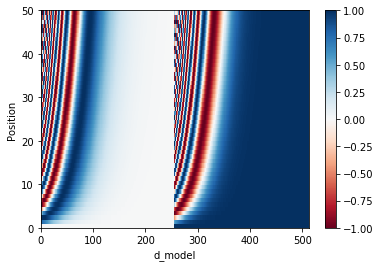

In [62]:
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d_model')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## encoder

In [0]:
class Encoder(tf.keras.layers.Layer):
  # Encoder 的初始參數除了本來就要給 EncoderLayer 的參數還多了：
  # - num_layers: 決定要有幾個 EncoderLayers, 前面影片中的 `N`
  # - input_vocab_size: 用來把索引轉成詞嵌入向量
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(input_vocab_size, self.d_model)
    
    # 建立 `num_layers` 個 EncoderLayers
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):
    # 輸入的 x.shape == (batch_size, input_seq_len)
    # 以下各 layer 的輸出皆為 (batch_size, input_seq_len, d_model)
    input_seq_len = tf.shape(x)[1]
    
    # 將 2 維的索引序列轉成 3 維的詞嵌入張量，並依照論文乘上 sqrt(d_model)
    # 再加上對應長度的位置編碼
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :input_seq_len, :]

    # 對 embedding 跟位置編碼的總合做 regularization
    # 這在 Decoder 也會做
    x = self.dropout(x, training=training)
    
    # 通過 N 個 EncoderLayer 做編碼
    for i, enc_layer in enumerate(self.enc_layers):
      x = enc_layer(x, training, mask)
      # 以下只是用來 demo EncoderLayer outputs
      #print('-' * 20)
      #print(f"EncoderLayer {i + 1}'s output:", x)
      
    
    return x 


In [64]:
# 超參數
num_layers = 2 # 2 層的 Encoder
d_model = 4
num_heads = 2
dff = 8
input_vocab_size = subword_encoder_en.vocab_size + 2 # 記得加上 <start>, <end>

# 初始化一個 Encoder
encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size)

# 將 2 維的索引序列丟入 Encoder 做編碼
enc_out = encoder(inp, training=False, mask=None)
print("inp:", inp)
print("-" * 20)
print("enc_out:", enc_out)

inp: tf.Tensor(
[[8113  103    9 1066 7903 8114    0    0]
 [8113   16 4111 6735   12 2750 7903 8114]], shape=(2, 8), dtype=int64)
--------------------
enc_out: tf.Tensor(
[[[-1.2790862   0.7277211   1.1928396  -0.6414745 ]
  [-0.78571904  0.26878226  1.5187829  -1.0018461 ]
  [ 1.1806064   0.30394346 -1.5824654   0.0979155 ]
  [-1.3284447   1.4864516   0.00227141 -0.1602782 ]
  [-1.418672    1.3559506   0.30228478 -0.23956338]
  [-1.4570699   1.216506    0.54930604 -0.3087421 ]
  [-1.3806121   0.9263376   0.9796738  -0.5253992 ]
  [-0.84081733  0.33215007  1.4899158  -0.9812486 ]]

 [[-1.2687426   0.67467296  1.2347566  -0.6406871 ]
  [-0.8262794   0.26496652  1.523539   -0.96222615]
  [ 0.14994699  1.5344563  -1.1618496  -0.52255356]
  [-1.3292937   1.4847274   0.01306123 -0.16849476]
  [-1.4258544   1.3461417   0.31523207 -0.23551914]
  [-1.4583664   1.2166135   0.5473705  -0.30561757]
  [-1.3994097   0.87126076  1.0200782  -0.49192938]
  [-0.9363468   0.38285995  1.4649131  -0.9114

## decoder

In [0]:
class Decoder(tf.keras.layers.Layer):
  # 初始參數跟 Encoder 只差在用 `target_vocab_size` 而非 `inp_vocab_size`
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, 
               rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    
    # 為中文（目標語言）建立詞嵌入層
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(target_vocab_size, self.d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
  
  # 呼叫時的參數跟 DecoderLayer 一模一樣
  def call(self, x, enc_output, training, 
           combined_mask, inp_padding_mask):
    
    tar_seq_len = tf.shape(x)[1]
    attention_weights = {}  # 用來存放每個 Decoder layer 的注意權重
    
    # 這邊跟 Encoder 做的事情完全一樣
    x = self.embedding(x)  # (batch_size, tar_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :tar_seq_len, :]
    x = self.dropout(x, training=training)

    
    for i, dec_layer in enumerate(self.dec_layers):
      x, block1, block2 = dec_layer(x, enc_output, training,
                                    combined_mask, inp_padding_mask)
      
      # 將從每個 Decoder layer 取得的注意權重全部存下來回傳，方便我們觀察
      attention_weights['decoder_layer{}_block1'.format(i + 1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i + 1)] = block2
    
    # x.shape == (batch_size, tar_seq_len, d_model)
    return x, attention_weights


In [67]:
# 超參數
num_layers = 2 # 2 層的 Decoder
d_model = 4
num_heads = 2
dff = 8
target_vocab_size = subword_encoder_zh.vocab_size + 2 # 記得加上 <start>, <end>

# 遮罩
inp_padding_mask = create_padding_mask(inp)
tar_padding_mask = create_padding_mask(tar)
look_ahead_mask = create_look_ahead_mask(tar.shape[1])
combined_mask = tf.math.maximum(tar_padding_mask, look_ahead_mask)

# 初始化一個 Decoder
decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size)

# 將 2 維的索引序列以及遮罩丟入 Decoder
print("tar:", tar)
print("-" * 20)
print("combined_mask:", combined_mask)
print("-" * 20)
print("enc_out:", enc_out)
print("-" * 20)
print("inp_padding_mask:", inp_padding_mask)
print("-" * 20)
dec_out, attn = decoder(tar, enc_out, training=False, 
                        combined_mask=combined_mask,
                        inp_padding_mask=inp_padding_mask)
print("dec_out:", dec_out)
print("-" * 20)
for block_name, attn_weights in attn.items():
  print(f"{block_name}.shape: {attn_weights.shape}")

tar: tf.Tensor(
[[4205   10  241   86   27    3 4206    0    0    0]
 [4205  165  489  398  191   14    7  560    3 4206]], shape=(2, 10), dtype=int64)
--------------------
combined_mask: tf.Tensor(
[[[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]]


 [[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 10, 10), dtype=float32)
--------------------
enc_out: tf.Tensor(
[[[-1.2790862  

## transformer

In [0]:
# Transformer 之上已經沒有其他 layers 了，我們使用 tf.keras.Model 建立一個模型
class Transformer(tf.keras.Model):
  # 初始參數包含 Encoder & Decoder 都需要超參數以及中英字典數目
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, rate)
    # 這個 FFN 輸出跟中文字典一樣大的 logits 數，等通過 softmax 就代表每個中文字的出現機率
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
  
  # enc_padding_mask 跟 dec_padding_mask 都是英文序列的 padding mask，
  # 只是一個給 Encoder layer 的 MHA 用，一個是給 Decoder layer 的 MHA 2 使用
  def call(self, inp, tar, training, enc_padding_mask, 
           combined_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, combined_mask, dec_padding_mask)
    
    # 將 Decoder 輸出通過最後一個 linear layer
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [69]:
# 超參數
num_layers = 1
d_model = 4
num_heads = 2
dff = 8

# + 2 是為了 <start> & <end> token
input_vocab_size = subword_encoder_en.vocab_size + 2
output_vocab_size = subword_encoder_zh.vocab_size + 2

# 重點中的重點。訓練時用前一個字來預測下一個中文字
tar_inp = tar[:, :-1]
tar_real = tar[:, 1:]

# 來源 / 目標語言用的遮罩。注意 `comined_mask` 已經將目標語言的兩種遮罩合而為一
inp_padding_mask = create_padding_mask(inp)
tar_padding_mask = create_padding_mask(tar_inp)
look_ahead_mask = create_look_ahead_mask(tar_inp.shape[1])
combined_mask = tf.math.maximum(tar_padding_mask, look_ahead_mask)

# 初始化我們的第一個 transformer
transformer = Transformer(num_layers, d_model, num_heads, dff, 
                          input_vocab_size, output_vocab_size)

# 將英文、中文序列丟入取得 Transformer 預測下個中文字的結果
predictions, attn_weights = transformer(inp, tar_inp, False, inp_padding_mask, 
                                        combined_mask, inp_padding_mask)

print("tar:", tar)
print("-" * 20)
print("tar_inp:", tar_inp)
print("-" * 20)
print("tar_real:", tar_real)
print("-" * 20)
print("predictions:", predictions)

tar: tf.Tensor(
[[4205   10  241   86   27    3 4206    0    0    0]
 [4205  165  489  398  191   14    7  560    3 4206]], shape=(2, 10), dtype=int64)
--------------------
tar_inp: tf.Tensor(
[[4205   10  241   86   27    3 4206    0    0]
 [4205  165  489  398  191   14    7  560    3]], shape=(2, 9), dtype=int64)
--------------------
tar_real: tf.Tensor(
[[  10  241   86   27    3 4206    0    0    0]
 [ 165  489  398  191   14    7  560    3 4206]], shape=(2, 9), dtype=int64)
--------------------
predictions: tf.Tensor(
[[[ 0.05138969 -0.03503799  0.01973152 ... -0.0774349   0.06403982
   -0.05701964]
  [-0.00393448  0.02586601 -0.01440323 ... -0.08027964  0.02729683
   -0.0315446 ]
  [ 0.00858721  0.02842965 -0.01311789 ... -0.07546385  0.04190227
   -0.03334414]
  ...
  [ 0.06376702 -0.06788289  0.03757301 ... -0.01717418  0.04855907
   -0.03828871]
  [ 0.06507304 -0.06963882  0.03755657 ... -0.04040997  0.05517247
   -0.04943693]
  [ 0.02500523  0.02616976 -0.00877443 ... -0.059

# 训练

## 损失函数

In [70]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# 假設我們要解的是一個 binary classifcation， 0 跟 1 個代表一個 label
real = tf.constant([1, 1, 0], shape=(1, 3), dtype=tf.float32)
pred = tf.constant([[0, 1], [0, 1], [0, 1]], dtype=tf.float32)
loss_object(real, pred)

<tf.Tensor: id=877339, shape=(3,), dtype=float32, numpy=array([0.31326166, 0.31326166, 1.3132616 ], dtype=float32)>

In [71]:
print("predictions:", predictions)
print("-" * 20)
print(tf.reduce_sum(predictions, axis=-1))

predictions: tf.Tensor(
[[[ 0.05138969 -0.03503799  0.01973152 ... -0.0774349   0.06403982
   -0.05701964]
  [-0.00393448  0.02586601 -0.01440323 ... -0.08027964  0.02729683
   -0.0315446 ]
  [ 0.00858721  0.02842965 -0.01311789 ... -0.07546385  0.04190227
   -0.03334414]
  ...
  [ 0.06376702 -0.06788289  0.03757301 ... -0.01717418  0.04855907
   -0.03828871]
  [ 0.06507304 -0.06963882  0.03755657 ... -0.04040997  0.05517247
   -0.04943693]
  [ 0.02500523  0.02616976 -0.00877443 ... -0.05971191  0.05614236
   -0.03216567]]

 [[ 0.05467369 -0.02312364  0.01638008 ... -0.05516092  0.06761045
   -0.04658468]
  [ 0.00212409  0.02911778 -0.01457848 ... -0.07755303  0.03516691
   -0.03197996]
  [ 0.0080609   0.03906634 -0.01706694 ... -0.06464574  0.04332972
   -0.02692928]
  ...
  [ 0.05936997 -0.05325023  0.03183686 ...  0.0055482   0.04423804
   -0.02466849]
  [ 0.05857209 -0.0261234   0.01923295 ... -0.03119083  0.06477293
   -0.03749833]
  [ 0.01487403  0.04520419 -0.01761724 ... -0.045

In [0]:
def loss_function(real, pred):
  # 這次的 mask 將序列中不等於 0 的位置視為 1，其餘為 0 
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  # 照樣計算所有位置的 cross entropy 但不加總
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask  # 只計算非 <pad> 位置的損失 
  
  return tf.reduce_mean(loss_)

In [0]:
# eval for tensorboard
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [74]:
# 训练用的超参
num_layers = 4 
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = subword_encoder_en.vocab_size + 2
target_vocab_size = subword_encoder_zh.vocab_size + 2
dropout_rate = 0.1  # 預設值

print("input_vocab_size:", input_vocab_size)
print("target_vocab_size:", target_vocab_size)

input_vocab_size: 8115
target_vocab_size: 4207


## optimizer

In [0]:
# 可自动调节步长
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  # 論文預設 `warmup_steps` = 4000
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
  
# 將客製化 learning rate schdeule 丟入 Adam opt.
# Adam opt. 的參數都跟論文相同
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

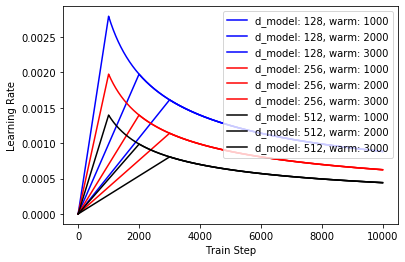

In [77]:
d_models = [128, 256, 512]
warmup_steps = [1000 * i for i in range(1, 4)]

schedules = []
labels = []
colors = ["blue", "red", "black"]
for d in d_models:
  schedules += [CustomSchedule(d, s) for s in warmup_steps]
  labels += [f"d_model: {d}, warm: {s}" for s in warmup_steps]

for i, (schedule, label) in enumerate(zip(schedules, labels)):
  plt.plot(schedule(tf.range(10000, dtype=tf.float32)), 
           label=label, color=colors[i // 3])

plt.legend()

plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 训练

In [78]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, dropout_rate)

print(f"""這個 Transformer 有 {num_layers} 層 Encoder / Decoder layers
d_model: {d_model}
num_heads: {num_heads}
dff: {dff}
input_vocab_size: {input_vocab_size}
target_vocab_size: {target_vocab_size}
dropout_rate: {dropout_rate}

""")

這個 Transformer 有 4 層 Encoder / Decoder layers
d_model: 128
num_heads: 8
dff: 512
input_vocab_size: 8115
target_vocab_size: 4207
dropout_rate: 0.1




In [0]:
# 為 Transformer 的 Encoder / Decoder 準備遮罩
def create_masks(inp, tar):
  # 英文句子的 padding mask，要交給 Encoder layer 自注意力機制用的
  enc_padding_mask = create_padding_mask(inp)
  
  # 同樣也是英文句子的 padding mask，但是是要交給 Decoder layer 的 MHA 2 
  # 關注 Encoder 輸出序列用的
  dec_padding_mask = create_padding_mask(inp)
  
  # Decoder layer 的 MHA1 在做自注意力機制用的
  # `combined_mask` 是中文句子的 padding mask 跟 look ahead mask 的疊加
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

In [80]:
# 方便比較不同實驗/ 不同超參數設定的結果
run_id = f"{num_layers}layers_{d_model}d_{num_heads}heads_{dff}dff_{train_perc}train_perc"
checkpoint_path = os.path.join(checkpoint_path, run_id)
log_dir = os.path.join(log_dir, run_id)

# tf.train.Checkpoint 可以幫我們把想要存下來的東西整合起來，方便儲存與讀取
# 一般來說你會想存下模型以及 optimizer 的狀態
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

# ckpt_manager 會去 checkpoint_path 看有沒有符合 ckpt 裡頭定義的東西
# 存檔的時候只保留最近 5 次 checkpoints，其他自動刪除
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果在 checkpoint 路徑上有發現檔案就讀進來
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  
  # 用來確認之前訓練多少 epochs 了
  last_epoch = int(ckpt_manager.latest_checkpoint.split("-")[-1])
  print(f'已讀取最新的 checkpoint，模型已訓練 {last_epoch} epochs。')
else:
  last_epoch = 0
  print("沒找到 checkpoint，從頭訓練。")

沒找到 checkpoint，從頭訓練。


In [0]:
@tf.function  # 讓 TensorFlow 幫我們將 eager code 優化並加快運算
def train_step(inp, tar):
  # 前面說過的，用去尾的原始序列去預測下一個字的序列
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  # 建立 3 個遮罩
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  # 紀錄 Transformer 的所有運算過程以方便之後做梯度下降
  with tf.GradientTape() as tape:
    # 注意是丟入 `tar_inp` 而非 `tar`。記得將 `training` 參數設定為 True
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    # 跟影片中顯示的相同，計算左移一個字的序列跟模型預測分佈之間的差異，當作 loss
    loss = loss_function(tar_real, predictions)

  # 取出梯度並呼叫前面定義的 Adam optimizer 幫我們更新 Transformer 裡頭可訓練的參數
  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  # 將 loss 以及訓練 acc 記錄到 TensorBoard 上，非必要
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [82]:
# 定義我們要看幾遍數據集
EPOCHS = 30
print(f"此超參數組合的 Transformer 已經訓練 {last_epoch} epochs。")
print(f"剩餘 epochs：{min(0, last_epoch - EPOCHS)}")


# 用來寫資訊到 TensorBoard，非必要但十分推薦
summary_writer = tf.summary.create_file_writer(log_dir)

# 比對設定的 `EPOCHS` 以及已訓練的 `last_epoch` 來決定還要訓練多少 epochs
for epoch in range(last_epoch, EPOCHS):
  start = time.time()
  
  # 重置紀錄 TensorBoard 的 metrics
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # 一個 epoch 就是把我們定義的訓練資料集一個一個 batch 拿出來處理，直到看完整個數據集 
  for (step_idx, (inp, tar)) in enumerate(train_dataset):
    
    # 每次 step 就是將數據丟入 Transformer，讓它生預測結果並計算梯度最小化 loss
    train_step(inp, tar)  

  # 每個 epoch 完成就存一次檔    
  if (epoch + 1) % 1 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  # 將 loss 以及 accuracy 寫到 TensorBoard 上
  with summary_writer.as_default():
    tf.summary.scalar("train_loss", train_loss.result(), step=epoch + 1)
    tf.summary.scalar("train_acc", train_accuracy.result(), step=epoch + 1)
  
  print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))
  print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

此超參數組合的 Transformer 已經訓練 0 epochs。
剩餘 epochs：-30
Saving checkpoint for epoch 1 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-1
Epoch 1 Loss 5.1780 Accuracy 0.0239
Time taken for 1 epoch: 148.21718907356262 secs

Saving checkpoint for epoch 2 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-2
Epoch 2 Loss 4.2421 Accuracy 0.0594
Time taken for 1 epoch: 23.814661502838135 secs

Saving checkpoint for epoch 3 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-3
Epoch 3 Loss 3.7383 Accuracy 0.0987
Time taken for 1 epoch: 25.15428638458252 secs

Saving checkpoint for epoch 4 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-4
Epoch 4 Loss 3.2597 Accuracy 0.1536
Time taken for 1 epoch: 45.83621573448181 secs

Saving checkpoint for epoch 5 at nmt/checkpoints/4layers_128d_8heads_512dff_20train_perc/ckpt-5
Epoch 5 Loss 2.9536 Accuracy 0.1830
Time taken for 1 epoch: 17.59086537361145 secs

Saving checkpoint for epoch 7 at nmt/checkpoints/

In [0]:
%load_ext tensorboard
%tensorboard --logdir {your_log_dir}

# evaluate

In [0]:
# 給定一個英文句子，輸出預測的中文索引數字序列以及注意權重 dict
def evaluate(inp_sentence):
  
  # 準備英文句子前後會加上的 <start>, <end>
  start_token = [subword_encoder_en.vocab_size]
  end_token = [subword_encoder_en.vocab_size + 1]
  
  # inp_sentence 是字串，我們用 Subword Tokenizer 將其變成子詞的索引序列
  # 並在前後加上 BOS / EOS
  inp_sentence = start_token + subword_encoder_en.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # 跟我們在影片裡看到的一樣，Decoder 在第一個時間點吃進去的輸入
  # 是一個只包含一個中文 <start> token 的序列
  decoder_input = [subword_encoder_zh.vocab_size]
  output = tf.expand_dims(decoder_input, 0)  # 增加 batch 維度
  
  # auto-regressive，一次生成一個中文字並將預測加到輸入再度餵進 Transformer
  for i in range(MAX_LENGTH):
    # 每多一個生成的字就得產生新的遮罩
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    

    # 將序列中最後一個 distribution 取出，並將裡頭值最大的當作模型最新的預測字
    predictions = predictions[: , -1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # 遇到 <end> token 就停止回傳，代表模型已經產生完結果
    if tf.equal(predicted_id, subword_encoder_zh.vocab_size + 1):
      return tf.squeeze(output, axis=0), attention_weights
    
    #將 Transformer 新預測的中文索引加到輸出序列中，讓 Decoder 可以在產生
    # 下個中文字的時候關注到最新的 `predicted_id`
    output = tf.concat([output, predicted_id], axis=-1)

  # 將 batch 的維度去掉後回傳預測的中文索引序列
  return tf.squeeze(output, axis=0), attention_weights

# predict

In [88]:
# 要被翻譯的英文句子
# sentence = "China, India, and others have enjoyed continuing economic growth."
sentence = "china is number one"
# 取得預測的中文索引序列
predicted_seq, _ = evaluate(sentence)

# 過濾掉 <start> & <end> tokens 並用中文的 subword tokenizer 幫我們將索引序列還原回中文句子
target_vocab_size = subword_encoder_zh.vocab_size
predicted_seq_without_bos_eos = [idx for idx in predicted_seq if idx < target_vocab_size]
predicted_sentence = subword_encoder_zh.decode(predicted_seq_without_bos_eos)

print("sentence:", sentence)
print("-" * 20)
print("predicted_seq:", predicted_seq)
print("-" * 20)
print("predicted_sentence:", predicted_sentence)

sentence: china is number one
--------------------
predicted_seq: tf.Tensor([4205  525   78    7], shape=(4,), dtype=int32)
--------------------
predicted_sentence: 愿之一


# summary

In [89]:
transformer.summary()

Model: "transformer_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_2 (Encoder)          multiple                  1831808   
_________________________________________________________________
decoder_2 (Decoder)          multiple                  1596800   
_________________________________________________________________
dense_141 (Dense)            multiple                  542703    
Total params: 3,971,311
Trainable params: 3,971,311
Non-trainable params: 0
_________________________________________________________________


# 可视化注意力

In [90]:
predicted_seq, attention_weights = evaluate(sentence)

# 在這邊我們自動選擇最後一個 Decoder layer 的 MHA 2，也就是 Decoder 關注 Encoder 的 MHA
layer_name = f"decoder_layer{num_layers}_block2"

print("sentence:", sentence)
print("-" * 20)
print("predicted_seq:", predicted_seq)
print("-" * 20)
print("attention_weights.keys():")
for layer_name, attn in attention_weights.items():
  print(f"{layer_name}.shape: {attn.shape}")
print("-" * 20)
print("layer_name:", layer_name)

sentence: china is number one
--------------------
predicted_seq: tf.Tensor([4205  525   78    7], shape=(4,), dtype=int32)
--------------------
attention_weights.keys():
decoder_layer1_block1.shape: (1, 8, 4, 4)
decoder_layer1_block2.shape: (1, 8, 4, 7)
decoder_layer2_block1.shape: (1, 8, 4, 4)
decoder_layer2_block2.shape: (1, 8, 4, 7)
decoder_layer3_block1.shape: (1, 8, 4, 4)
decoder_layer3_block2.shape: (1, 8, 4, 7)
decoder_layer4_block1.shape: (1, 8, 4, 4)
decoder_layer4_block2.shape: (1, 8, 4, 7)
--------------------
layer_name: decoder_layer4_block2


In [0]:
import matplotlib as mpl
# 你可能會需要自行下載一個中文字體檔案以讓 matplotlib 正確顯示中文
#zhfont = mpl.font_manager.FontProperties(fname='/usr/share/fonts/SimHei/simhei.ttf')
#plt.style.use("seaborn-whitegrid")

# 這個函式將英 -> 中翻譯的注意權重視覺化（注意：我們將注意權重 transpose 以最佳化渲染結果
def plot_attention_weights(attention_weights, sentence, predicted_seq, layer_name, max_len_tar=None):
    
  fig = plt.figure(figsize=(17, 7))
  
  sentence = subword_encoder_en.encode(sentence)
  
  # 只顯示中文序列前 `max_len_tar` 個字以避免畫面太過壅擠
  if max_len_tar:
    predicted_seq = predicted_seq[:max_len_tar]
  else:
    max_len_tar = len(predicted_seq)
  
  # 將某一個特定 Decoder layer 裡頭的 MHA 1 或 MHA2 的注意權重拿出來並去掉 batch 維度
  attention_weights = tf.squeeze(attention_weights[layer_name], axis=0)  
  # (num_heads, tar_seq_len, inp_seq_len)
  
  # 將每個 head 的注意權重畫出
  for head in range(attention_weights.shape[0]):
    ax = fig.add_subplot(2, 4, head + 1)

    # [注意]我為了將長度不短的英文子詞顯示在 y 軸，將注意權重做了 transpose
    attn_map = np.transpose(attention_weights[head][:max_len_tar, :])
    ax.matshow(attn_map, cmap='viridis')  # (inp_seq_len, tar_seq_len)
    
    #fontdict = {"fontproperties": zhfont}
    
    ax.set_xticks(range(max(max_len_tar, len(predicted_seq))))
    ax.set_xlim(-0.5, max_len_tar -1.5)
    
    ax.set_yticks(range(len(sentence) + 2))
    ax.set_xticklabels([subword_encoder_zh.decode([i]) for i in predicted_seq 
                        if i < subword_encoder_zh.vocab_size], fontsize=18) 
                       #fontdict=fontdict, fontsize=18)    
    
    ax.set_yticklabels(
        ['<start>'] + [subword_encoder_en.decode([i]) for i in sentence] + ['<end>'])#, 
        #fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head + 1))
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
  
  plt.tight_layout()
  plt.show()
  plt.close(fig)

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 24895 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 20043 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 19968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:176: RuntimeWarning: Glyph 24895 missing from current font.
  font.load_char(ord(s), flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:176: RuntimeWarning: Glyph 20043 missing from current font.
  font.load_char(ord(s), flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:176: RuntimeWarning: Glyph 19968 missing from current font.
  font.lo

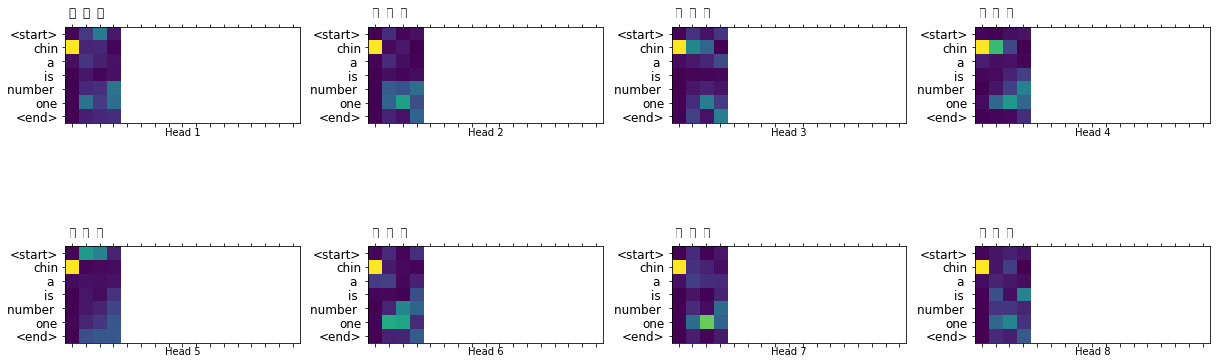

In [92]:
plot_attention_weights(attention_weights, sentence, 
                       predicted_seq, layer_name, max_len_tar=18)